In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from IPython.display import Image, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

plt.rcParams["figure.figsize"] = [15, 7]
plt.style.use('ggplot')

## Prepr Machine Learning Challenge

This notebook was created for the Prepr Machine Learning Challenge.

The data are all available from [this link](https://www150.statcan.gc.ca/n1/daily-quotidien/190308/dq190308a-eng.htm). Specifically, the sources cite that information is found in the following tables, which I will use to conduct the analysis. 

* Statistics Canada.  [Table  14-10-0355-01](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=1410035501#timeframe)   Employment by industry, monthly, seasonally adjusted and unadjusted, and trend-cycle, last 5 months (x 1,000)

* Statistics Canada.  [Table  14-10-0287-01](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=1410028701)   Labour force characteristics, monthly, seasonally adjusted and trend-cycle, last 5 months

* Statistics Canada.  [Table  14-10-0288-01](https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=1410028801#timeframe)   Employment by class of worker, monthly, seasonally adjusted and unadjusted, last 5 months (x 1,000)


The license for the usage of this dataset can be found [here](https://www.statcan.gc.ca/eng/reference/licence). 


Further more, we will be using a job skills data set provided by the Prepr team. 

## Part 1: Employment by industry 

For the purposes of this analysis, we will be using the following columns. 

In [2]:
df_industry = pd.read_csv("Industry_province.csv")

df_industry.rename(columns={"North American Industry Classification System (NAICS)": "NAICS", 
                            "REF_DATE": "Date",
                            "VALUE": "Value"}, inplace=True)

columns = ["Date", "NAICS", "Value", "GEO"]

df_industry[columns].sample(5, random_state=42)

,Date,NAICS,Value,GEO
8934,2017-06,Educational services [61],50.6,Manitoba
4634,2020-01,Public administration [91],29.2,Nova Scotia
7749,2015-04,Educational services [61],521.0,Ontario
6400,2019-10,Transportation and warehousing [48-49],242.7,Quebec
10754,2016-08,Construction [23],246.4,Alberta


We note that the value has a scalar multiplier of 3. For now, we will keep the values as is.

In [3]:
print("Total number of missing values for each column: ")

df_industry[columns].isna().sum()

Total number of missing values for each column: 


Date     0
NAICS    0
Value    8
GEO      0
dtype: int64

In [4]:
df_industry[df_industry["Value"].isna()]

,Date,GEO,DGUID,NAICS,Statistics,Data type,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,Value,STATUS,SYMBOL,TERMINATED,DECIMALS
2590,2017-06,Prince Edward Island,2016A000211,Utilities [22],Estimate,Seasonally adjusted,Persons,249,thousands,3,v2057645,3.5.1.1,NaN,x,NaN,NaN,1
2591,2017-07,Prince Edward Island,2016A000211,Utilities [22],Estimate,Seasonally adjusted,Persons,249,thousands,3,v2057645,3.5.1.1,NaN,x,NaN,NaN,1
2592,2017-08,Prince Edward Island,2016A000211,Utilities [22],Estimate,Seasonally adjusted,Persons,249,thousands,3,v2057645,3.5.1.1,NaN,x,NaN,NaN,1
2593,2017-09,Prince Edward Island,2016A000211,Utilities [22],Estimate,Seasonally adjusted,Persons,249,thousands,3,v2057645,3.5.1.1,NaN,x,NaN,NaN,1
2594,2017-10,Prince Edward Island,2016A000211,Utilities [22],Estimate,Seasonally adjusted,Persons,249,thousands,3,v2057645,3.5.1.1,NaN,x,NaN,NaN,1
2595,2017-11,Prince Edward Island,2016A000211,Utilities [22],Estimate,Seasonally adjusted,Persons,249,thousands,3,v2057645,3.5.1.1,NaN,x,NaN,NaN,1
2596,2017-12,Prince Edward Island,2016A000211,Utilities [22],Estimate,Seasonally adjusted,Persons,249,thousands,3,v2057645,3.5.1.1,NaN,x,NaN,NaN,1
2597,2018-01,Prince Edward Island,2016A000211,Utilities [22],Estimate,Seasonally adjusted,Persons,249,thousands,3,v2057645,3.5.1.1,NaN,x,NaN,NaN,1


We notice that there are missing values for the utilities industry in Prince Edward Island. According to the table sourced, this missing value is 'to meet the confidentiality requirements of the Statistics Act'. For the purposes of this analysis, we will assume that this is due to there being a low number of people employed in this sector in Prince Edward Island, and therefore we will replace these values with 0. 

In [5]:
df_industry["Value"].fillna(0, inplace=True)

In [6]:
print("Below are all the values for the NAICS column: \n")
_ =[print(industry) for industry in df_industry["NAICS"].unique()]

Below are all the values for the NAICS column: 

Total employed, all industries
Goods-producing sector
Agriculture [111-112, 1100, 1151-1152]
Forestry, fishing, mining, quarrying, oil and gas [21, 113-114, 1153, 2100]
Utilities [22]
Construction [23]
Manufacturing [31-33]
Services-producing sector
Wholesale and retail trade [41, 44-45]
Transportation and warehousing [48-49]
Finance, insurance, real estate, rental and leasing [52-53]
Professional, scientific and technical services [54]
Business, building and other support services [55-56]
Educational services [61]
Health care and social assistance [62]
Information, culture and recreation [51, 71]
Accommodation and food services [72]
Other services (except public administration) [81]
Public administration [91]


Next, we take a look at the employment rates for each of the industries above for different provinces. Below is an interactive graph that allows the choice of which province and industry to analyse. 

In [7]:
def plot_industry(Industry, Province):
    filter_ = (df_industry["NAICS"] == Industry) & (df_industry["GEO"] == Province)
    df_selected = df_industry[filter_]
    plt.plot(df_selected["Date"], df_selected["Value"])
    plt.xticks(range(0, 12*5 + 1, 12), ["2015-02", "2016-02", "2017-02", "2018-02", "2019-02", "2020-02"])
    plt.title("Employment for {} in {}".format(Industry, Province))
    plt.ylabel("Num employed (x1000)")
    
_ = interact(plot_industry, Industry=df_industry["NAICS"].unique(), Province=df_industry["GEO"].unique())

interactive(children=(Dropdown(description='Industry', options=('Total employed, all industries', 'Goods-produ…

We note that the number represents the NAICS code. More information and detail about each sector can be found [here](https://www23.statcan.gc.ca/imdb/p3VD.pl?Function=getVD&TVD=380372&CVD=380373&CLV=0&MLV=5&D=1). 

I have prepared a dataframe that includes the sectors described in the website above and a description of what each sector. The code is available in the scraping file. Below I included an example of a description. At the time of writing, it's unclear weather this will be useful, however I prepared it just in case. 

In [8]:
df_desc = pd.read_csv("NAICS_desc.csv").drop(columns=["Unnamed: 0"])

In [9]:
print("Example description of {}:".format(df_desc["Name"].iloc[0]))

print(df_desc["Description"].iloc[0])

Example description of 11 - Agriculture, forestry, fishing and hunting :

 This sector comprises establishments primarily engaged in growing crops, raising animals, harvesting timber, harvesting fish and other animals from their natural habitats and providing related support activities.
 
 
 Establishments primarily engaged in agricultural research or that supply veterinary services are not included in this sector.




## Part 2: Labour characteristics

Next, we take a look at the labour data.

In [10]:
df_labour = pd.read_csv("Labour_force.csv")

The labour force data has several kinds of statistics:

* Population
* Labour force
    * Employment
    * Full-Time Employment
    * Part-Time Employment
    * Unemployment

* Unemployment_rate
* Participation_rate
* Employment_rate

Below are some examples of the statistics. 
We will be considering only a few fields.

In [11]:
labour_categories = ["Date", "Characteristics", "Sex", "Age group", "Value"]
df_labour.rename(columns={"REF_DATE": "Date",
                          "Labour force characteristics": "Characteristics", 
                         "VALUE": "Value"}, inplace=True)

df_labour[labour_categories].sample(5, random_state=42)

,Date,Characteristics,Sex,Age group,Value
1643,2019-11,Employment,Females,55 to 64 years,1525.3
3554,2016-06,Participation rate,Both sexes,25 to 54 years,86.3
3066,2016-06,Unemployment rate,Both sexes,55 to 64 years,6.3
3407,2019-06,Unemployment rate,Females,25 to 54 years,4.3
2554,2019-07,Unemployment,Both sexes,55 to 64 years,176.8


In [12]:
df_labour[labour_categories].isna().sum()

Date               0
Characteristics    0
Sex                0
Age group          0
Value              0
dtype: int64

There are no missing values, and thus we won't have to do any cleaning in this regard. 

Below is an interactive graph that allows the choice of which Characteristic, Sex, and Age group to use for filtering the data. 

In [13]:
def plot_labour(Characteristic, Sex, Age_Group):
    filter_1 = (df_labour["Characteristics"] == Characteristic)
    filter_2 = (df_labour["Sex"] == Sex)
    filter_3 = (df_labour["Age group"] == Age_Group)
    filter_ = filter_1 & filter_2 & filter_3
    df_selection = df_labour[filter_]
    
    plt.plot(df_selection["Date"], df_selection["Value"])
    plt.xticks(range(0, 12*5 + 1, 12), ["2015-02", "2016-02", "2017-02", "2018-02", "2019-02", "2020-02"])
    plt.title("{} for {} in {} group".format(Characteristic, Sex, Age_Group))
    if(df_selection["SCALAR_ID"].iloc[0] == 3):
        plt.ylabel("{} (x1000)".format(Characteristic))
    else:
        plt.ylabel("{}".format(Characteristic))

_ = interact(plot_labour, Characteristic = df_labour["Characteristics"].unique(), Sex = df_labour["Sex"].unique(), 
             Age_Group = df_labour["Age group"].unique())



interactive(children=(Dropdown(description='Characteristic', options=('Population', 'Labour force', 'Employmen…

## Part 3a: Job skills with keyword analysis

Next, we take a look at the job skills dataframe. 

In [14]:
df_jobs = pd.read_csv("job_skills.csv")

In [15]:
df_jobs.sample(5, random_state=42)

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
680,Google,"Partner Marketing Manager, Google Cloud Market...",Marketing & Communications,"Tokyo, Japan",Develop and manage the partner marketing strat...,BA/BS degree or equivalent practical experienc...,Experience working with and selling via online...
1102,Google,"HR Business Partner, Employee Relations",People Operations,"Dublin, Ireland",Partner with the other Global Investigations t...,BA/BS degree or equivalent practical experienc...,CIPD qualification or equivalent.\nExperience ...
394,Google,"App Specialist LCS (CEE), App Developer Sales,...",Sales & Account Management,"Dublin, Ireland",Assist LCS teams to identify and promote oppor...,BA/BS degree or equivalent practical experienc...,Experience advising customers on mobile app st...
930,Google,"Go-to-Market Lead, Southeast Asia/India Partne...",Business Strategy,Singapore,Work with the SEA leadership team on business ...,6 years of experience in strategic management ...,Successful track record of developing business...
497,Google,"Field Sales Representative, Google Cloud",Sales & Account Management,"Chicago, IL, United States",Build and maintain executive relationships wit...,BA/BS degree or equivalent practical experienc...,10 years of experience selling IaaS or PaaS wi...


We will be using the responsibilities field to identify the industry each job belongs to. To do this, we will be using nltk to extract key words.

In [16]:
print(df_jobs["Responsibilities"].iloc[0])

Shape, shepherd, ship, and show technical programs designed to support the work of Cloud Customer Engineers and Solutions Architects.
Measure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.
Communicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.
Establish expectations and rationale on deliverables for stakeholders and program contributors.
Provide program performance feedback to teams in Product, Engineering, Sales, and Marketing (among others) to enable efficient cross-team operations.


In [17]:
# Getting rid of missing values.
df_jobs.isna().sum()

Company                      0
Title                        0
Category                     0
Location                     0
Responsibilities            15
Minimum Qualifications      14
Preferred Qualifications    14
dtype: int64

In [18]:
df_jobs[df_jobs["Responsibilities"].isna()]

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
15,Google,Manufacturing Test Engineer,Hardware Engineering,"South San Francisco, CA, United States",NaN,NaN,NaN
72,Google,"Software Engineer, Android Applications, Veril...",Software Engineering,"Cambridge, MA, United States",NaN,NaN,NaN
91,Google,"Analog / Mixed Signal IC Design Engineer, Veri...",Hardware Engineering,"South San Francisco, CA, United States",NaN,NaN,NaN
97,Google,"Program Manager, Behavioral Health, Verily Lif...",Program Management,"South San Francisco, CA, United States",NaN,NaN,NaN
98,Google,"Software Engineer, Android Applications, Veril...",Software Engineering,"South San Francisco, CA, United States",NaN,NaN,NaN
123,Google,"Manufacturing Engineer, Verily Life Sciences -...",Hardware Engineering,"South San Francisco, CA, United States",NaN,NaN,NaN
150,Google,"IC Test Engineer, Verily Life Sciences - South...",Hardware Engineering,"South San Francisco, CA, United States",NaN,NaN,NaN
160,Google,"Software Engineer, Verily Life Sciences - Sout...",Software Engineering,"South San Francisco, CA, United States",NaN,NaN,NaN
202,Google,"Firmware Engineer, Verily Life Sciences - Sout...",Software Engineering,"South San Francisco, CA, United States",NaN,NaN,NaN
206,Google,"Software Test Engineer, Mobile and Web Applica...",Software Engineering,"Mountain View, CA, United States",NaN,NaN,NaN


Since there are little jobs that have missing values, it will be safe to get rid of them to ease the analysis process. 

In [19]:
df_jobs.dropna(inplace=True)

Whilst performing some analysis, I noticed that one of the entries is not in english. We will remove this as well. 

In [20]:
english_filter = df_jobs["Responsibilities"].str.match("[a-zA-Z\s]")
df_jobs[~english_filter]

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
100,Google,ソフトウェア エンジニア、Chrome OS ビデオ,Software Engineering,"Tokyo, Japan",デバイス、ドライバに加え、Chrome OS、Android などの Linux ベースシス...,コンピュータ サイエンスまたは関連する技術分野で学士号を取得していること（関連職種での実務経...,コンピュータ サイエンスまたは関連する技術分野での修士号または博士号\nドメインに関する知識...


In [21]:
df_jobs = df_jobs[english_filter].copy()

We also notice that there are several duplicate jobs. Here is one example:

In [22]:
df_jobs[df_jobs["Title"] == "MBA Intern 2018"].head(4)

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
618,Google,MBA Intern 2018,Administrative,"Xinyi District, Taiwan",Intern projects will be determined based on th...,Must be a first year student in a two year ful...,Work experience prior to the MBA program in Sa...
634,Google,MBA Intern 2018,Administrative,Singapore,Intern projects will be determined based on th...,Must be a first year student in a two year ful...,Work experience prior to the MBA program in Sa...
675,Google,MBA Intern 2018,Administrative,"Beijing, China",Intern projects will be determined based on th...,Must be a first year student in a two year ful...,Work experience prior to the MBA program in Sa...
684,Google,MBA Intern 2018,Administrative,"Bangkok, Thailand",Intern projects will be determined based on th...,Must be a first year student in a two year ful...,Work experience prior to the MBA program in Sa...


We will be removing duplicate rows from the dataset, and store a version with all jobs inside another dataframe.

In [23]:
df_jobs_all = df_jobs.copy()
df_jobs.drop_duplicates(["Responsibilities"], inplace=True)

We will be performing keyword extraction with nltk and sklearn. First however, we will need to do some preprocessing. We will tokenize each text and use lemmatization to get a cleaner data set. Then, we will use the TF-IDF vectorizer to help find keywords. 

In [24]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [26]:
# Code from https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [27]:
lem = WordNetLemmatizer()

def lemmatize(text):
    clean = re.sub("[^\w\s]|\\n", " ", text) #Get rid of punctuation and newline.
    token = word_tokenize(clean)
    pos = nltk.pos_tag(token)
    res = [(word, nltk_tag_to_wordnet_tag(tag)) for word, tag in pos]
    new_words = [lem.lemmatize(word, pos=tag) for word, tag in res if tag is not None]
    text = ""
    for word in new_words:
        text += (word + " ")
    return text

In [28]:
df_jobs_tfidf = df_jobs[["Title", "Category", "Responsibilities"]].copy()

In [29]:
df_jobs_tfidf["Res_clean"] = df_jobs_tfidf["Responsibilities"].apply(lemmatize)

In [30]:
vectorizer = TfidfVectorizer(stop_words = set(stopwords.words('english')))
result = vectorizer.fit_transform(df_jobs_tfidf["Res_clean"])

In [31]:
word_vector = pd.Series(vectorizer.get_feature_names())
NUM_KEYWORDS = 8

In [32]:
print("The identified keywords for the first job in the job_skills dataset is:")

word_vector.iloc[pd.Series(result[0].toarray().flatten()).nlargest(NUM_KEYWORDS).index]

The identified keywords for the first job in the job_skills dataset is:


2118        program
190      architects
380          cancel
2829    transparent
625     contributor
2209      rationale
2485       shepherd
2487           ship
dtype: object

In [33]:
result_small = np.zeros(result.shape)
for i in range(result.shape[0]):
    for index in pd.Series(result[i].toarray().flatten()).nlargest(NUM_KEYWORDS).index:
        result_small[i, index] = result[i, index]

Next, we can use k-means clustering to group together different jobs, then find the different centroids. 

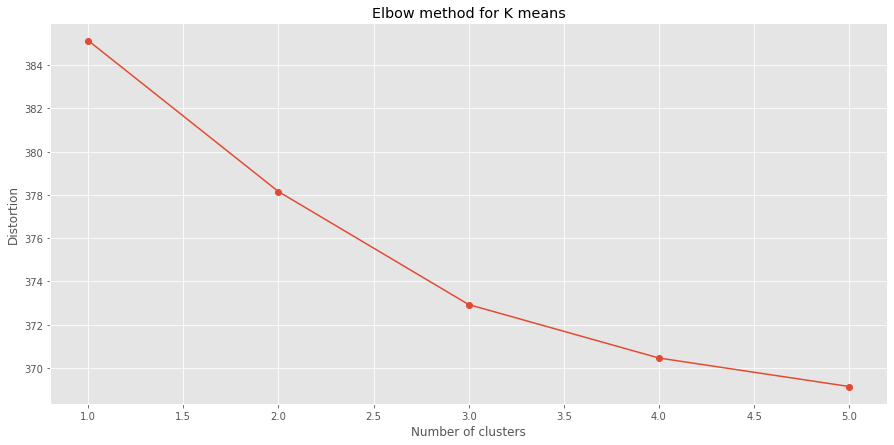

In [34]:
# Elbow method from https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

# Takes a while to run, so enjoy a nice coffee while running this if you're curious. 
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 6):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(result_small)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 6), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
tit = plt.title("Elbow method for K means")

Based on the graph above, the elbow is rather hard to discern. For now, we will be using 3 clusters. Further investigation can be done in the future. 

We can then show the job categories captured by the clusters.

In [35]:
cluster = KMeans(n_clusters=3, random_state=0, max_iter=300)
labels = cluster.fit(result_small)
df_jobs_tfidf["group"] = labels.labels_

In [36]:
for i in range(3):
    print("The keywords for cluster {} is:".format(i))
    j = 1
    for word in word_vector.iloc[pd.Series(labels.cluster_centers_[i]).nlargest(NUM_KEYWORDS).index].values:
        print("{}. {}".format(j, word))
        j+=1
    

The keywords for cluster 0 is:
1. customer
2. business
3. advertiser
4. technical
5. tailor
6. phone
7. strategic
8. consultative
The keywords for cluster 1 is:
1. partner
2. google
3. cloud
4. service
5. joint
6. partnership
7. business
8. day
The keywords for cluster 2 is:
1. client
2. product
3. technical
4. agency
5. user
6. policy
7. design
8. legal


In [37]:
df_graph = pd.DataFrame([0]*23, index=df_jobs["Category"].unique())

vals = [df_jobs_tfidf[df_jobs_tfidf["group"] == i]["Category"].value_counts(normalize=True) for i in range(3)]


In [38]:
for i in range(3):
    df_graph = df_graph.merge(pd.DataFrame({"Cluster{}".format(i) : vals[i]})
                              , how="outer", left_index=True, right_index=True)

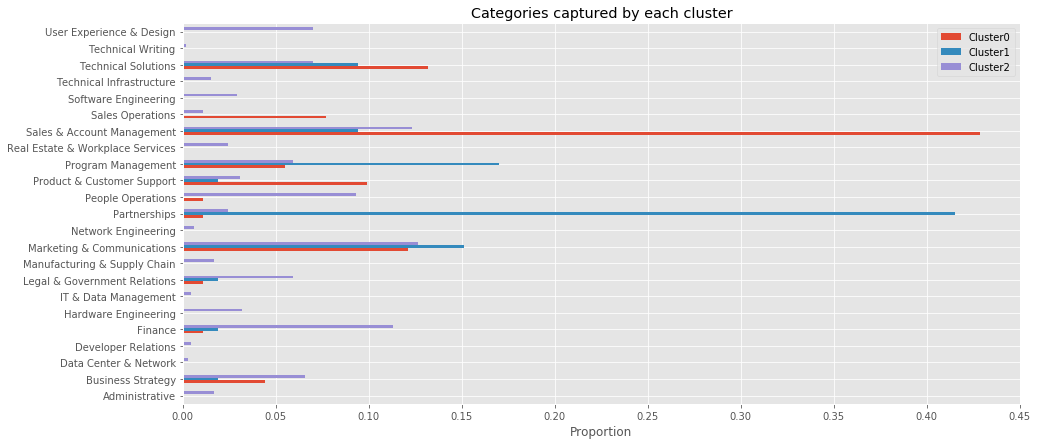

In [39]:
graph = df_graph.fillna(0).drop(columns=[0]).plot.barh()
plt.xlabel("Proportion")
tit = plt.title("Categories captured by each cluster")

What we can see in the graph above is that cluster 0 mostly captured Sales & Account Management, whereas cluster 1 captured mostly Partnerships. In future investigations, cluster 2 can be split up even more. 

I wished that we can use this keyword analysis to be able to deduce which industry each category belongs in, however it seems that since the job skills dataset is rather limited (since it includes only jobs from google and youtube), this was not as effective as it can be. The clustering data above does help to some extent, however. 

For example, we can see that since cluster 2 captured both Hardware Engineering, Network Engineering and Software Engineering while the other clusters did not, we can deduce that they are similar jobs with similar responsibilities and keywords, and thus belong to the same industry. 

However, for other jobs such as Markerting & communications where all three clusters captured a rougly equal proportion, we can deduce that the skills and responsibilities in that job are more diverse. 


According to some [sources](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e), using a large dimension clustering method may not be suitable, so maybe we can also implement PCA for the clustering. 

Below is an attempt of clustering with PCA applied. However, since PCA is applied, we no longer have a representation of what the keywords for each centroid is. 

In [40]:
pca = PCA(n_components=2)
new_result = pca.fit_transform(result_small)

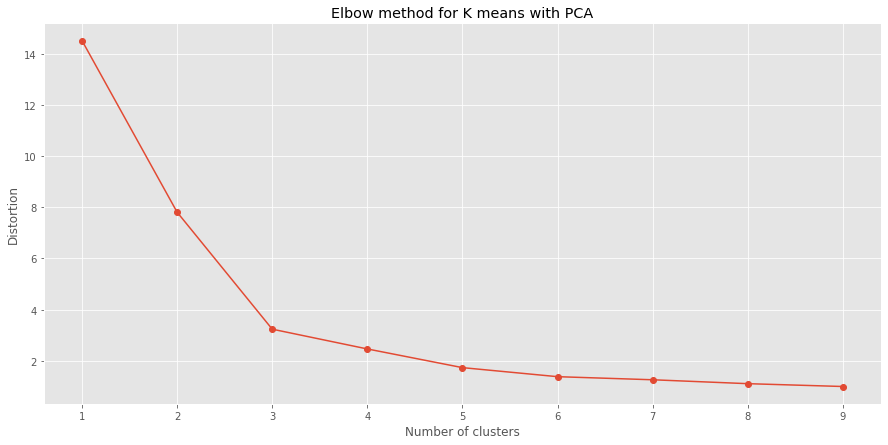

In [41]:
distortions = []
for i in range(1, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(new_result)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
tit = plt.title("Elbow method for K means with PCA")

The elbow is more distinct above, and thus we will choose n = 3. 

In [42]:
cluster = KMeans(n_clusters=3, random_state=0)
labels = cluster.fit(new_result)
df_jobs_tfidf["group_pca"] = labels.labels_

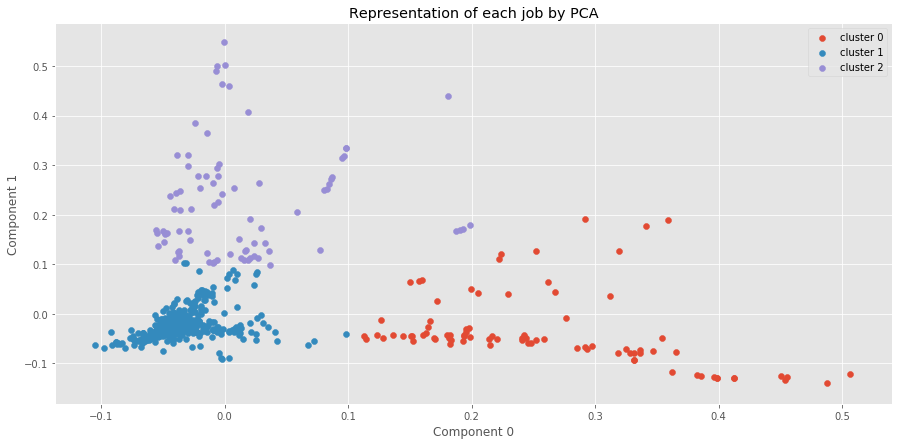

In [43]:
df_rep = pd.DataFrame(new_result)
df_rep["label"] = labels.labels_
for i in range(3):
    plt.scatter(df_rep[df_rep["label"] == i][0], df_rep[df_rep["label"] == i][1], label="cluster {}".format(i))
    
plt.xlabel("Component 0"), plt.ylabel("Component 1")
tit, leg = plt.title("Representation of each job by PCA"), plt.legend()

In [44]:
df_graph = pd.DataFrame([0]*23, index=df_jobs["Category"].unique())

vals = [df_jobs_tfidf[df_jobs_tfidf["group_pca"] == i]["Category"].value_counts(normalize=True) for i in range(3)]

for i in range(3):
    df_graph = df_graph.merge(pd.DataFrame({"Cluster{}".format(i) : vals[i]})
                              , how="outer", left_index=True, right_index=True)

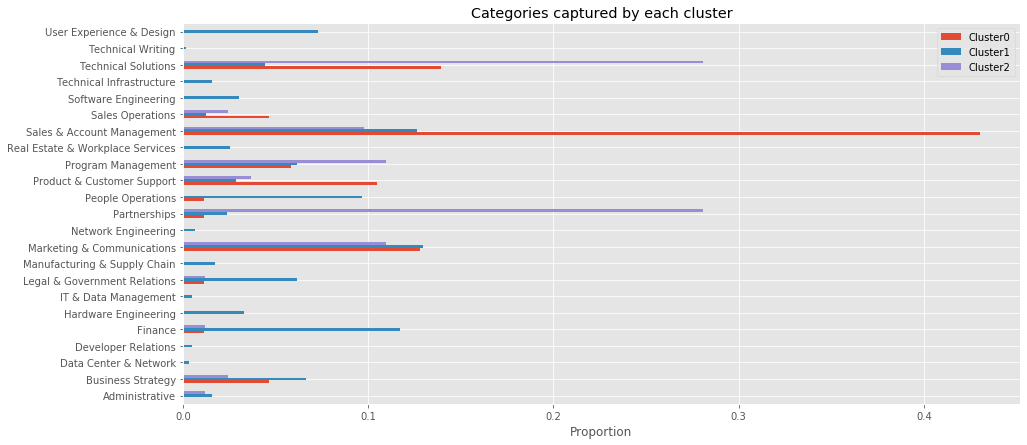

In [45]:
graph = df_graph.fillna(0).drop(columns=[0]).plot.barh()
plt.xlabel("Proportion")
tit = plt.title("Categories captured by each cluster")

The results are still mostly similar. Cluster 1 can be divided into several other clusters, and captures some job categories that are similar, such as network engineering, software engineering and harware engineering. Meanwhile, Markerting & Communications are still captured in a similar ratio to the clustering without PCA. 

## Part3b: Job skills with manual analysis


For the purposes of this analysis however, I will also manually create a dictionary that maps each job category into their respective industry. 

In [46]:
# An attempt to using keywords in the descriptions to categorize into industries. 

# df_desc["Desc_clean"] = df_desc["Description"].apply(lemmatize)
# desc_result = vectorizer.fit_transform(df_desc["Desc_clean"])
# desc_vector = pd.Series(vectorizer.get_feature_names())

# key_words_list = []
# for i in range(df_desc.shape[0]):
#     key_words = desc_vector.iloc[pd.Series(desc_result[i].toarray().flatten()).nlargest(NUM_KEYWORDS).index].values
#     key_words = set(key_words)
#     key_words_list.append(key_words)
    
# df_desc["key_words"] = key_words_list

In [47]:
category_to_industry = {
"Program Management"          : "Business, building and other support services [55-56]",
"Manufacturing & Supply Chain": "Manufacturing [31-33]",
"Technical Solutions"         : "Professional, scientific and technical services [54]",
"Developer Relations"         : "Professional, scientific and technical services [54]",
"Hardware Engineering"        : "Professional, scientific and technical services [54]",
"Partnerships"                : "Business, building and other support services [55-56]",
"Product & Customer Support"  : "Business, building and other support services [55-56]", 
"Software Engineering"        : "Professional, scientific and technical services [54]",
"Data Center & Network"       : "Professional, scientific and technical services [54]",
"Business Strategy"           : "Business, building and other support services [55-56]",
"Technical Writing"           : "Professional, scientific and technical services [54]",
"Technical Infrastructure"    : "Professional, scientific and technical services [54]",
"IT & Data Management"        : "Professional, scientific and technical services [54]", 
"Marketing & Communications"  : "Business, building and other support services [55-56]",
"Network Engineering"         : "Professional, scientific and technical services [54]",
"Sales & Account Management"  : "Business, building and other support services [55-56]",
"Sales Operations"            : "Business, building and other support services [55-56]",
"Finance"                     : "Finance, insurance, real estate, rental and leasing [52-53]",
"Legal & Government Relations": "Professional, scientific and technical services [54]",
"Administrative"              : "Business, building and other support services [55-56]",
"User Experience & Design"    : "Professional, scientific and technical services [54]",
"People Operations"           : "Business, building and other support services [55-56]",
"Real Estate & Workplace Services": "Finance, insurance, real estate, rental and leasing [52-53]"
}

In [48]:
df_jobs_man = df_jobs_all.copy()
df_jobs_man["Industry"] = df_jobs_man["Category"].apply(lambda x : category_to_industry[x])

In [49]:
industries = set(category_to_industry.values())

In [50]:
industry_to_prop= {}
for industry in industries:
    industry_to_prop[industry] = df_jobs_man[df_jobs_man["Industry"] == industry]["Category"].value_counts(normalize=True)

We will calculate the proportion of jobs in each industry, and use that value to calculate the estimated employment. There are however, some large limitations with this, as we are only working with jobs from Google. Therefore, we are under the implicit assumption that the distribution of jobs in Google represents the distribution of jobs in Canada. In the future, we can either test this hypothesis using hypothesis testing given that we have a larger dataset containing jobs in Canada. This might be done by scraping sites such as Indeed, Glassdoor and LinkedIn, however I have yet to do research on the privacy policies on scraping their site. 


Secondly, since we do not have jobs available for different time frames, this means that the graphs that we have provided will stay within a factor of the overall industry total. 

In [51]:
def plot_category(Category, Province):
    
    df_selection = df_industry[df_industry["GEO"] == Province]
    industry = category_to_industry[Category]
    factor = industry_to_prop[industry].loc[Category]
    df_selection = df_selection[df_selection["NAICS"] == industry]
    df_selection["Value"] = df_selection["Value"] * factor
    
    plt.plot(df_selection["Date"], df_selection["Value"])
    plt.xticks(range(0, 12*5 + 1, 12), ["2015-02", "2016-02", "2017-02", "2018-02", "2019-02", "2020-02"])
    plt.title("Employment for {} in {}".format(Category, Province))
    plt.ylabel("Num employed (x1000)")
    
_ = interact(plot_category, Category = df_jobs_man["Category"].unique(), Province = df_industry["GEO"].unique())

interactive(children=(Dropdown(description='Category', options=('Program Management', 'Manufacturing & Supply …

## Conclusion and Future improvements

Given enough suitable data, we can perhaps use logistic regression to solve the problem of getting a visualization of skills and responsibilities to industry and employment. This would required labelled data, where an expert has already previously allocated jobs to their respective industries. Afterwards, we can train a machine learning model to predict the industry given a specific word vector, that might be condensed either by using a similar key word technique described above or other dimension reductionality methods, such as Principal Component Analysis. 

Similarly, we can improve the keyword analysis if we were given a larger dataset with a more diverse set of responsibilities, as it would improve the TF-IDF's ability to detect key words. We could also do the same key word analysis with the Qualifications field, as it might contain information that may help identify the industry. However due to the time constraints at the time of writing this might be done in the future. 

There might also be improvements to the clustering if there are more data points. It might also be beneficial to experiment with different clustering algorithms. 

I hope that this notebook proved to be useful and enlightening. This notebook helped me learn a few new skills, such as the TF-IDF method of extracting key words as well as lemmatization. If there are any questions, please do not hesistate to contact me at the following email:

think.smart318@gmail.com

